# Question 1
 How are income, race, and pollution relevant to EV charger number in the State of California? Can we use demographic characteristics to predict where future EV chargers will be built?


For this question, we used data from the 
- 2020 American Community Survey (5-Year Estimate) 
- CalEnviroScreen 4.0
- National Renewable Energy Laboratory electric vehicle public charger locations

We acquired ACS data using the census.gov API since the dataset was not available via the cenpy package. We pulled median household income, median gross rent, and housing unit data. Then we joined the data from ACS to the CalEnviroScreen shapefile. We also requested charger locations from NREL and filtered the dataset to only return public chargers. We then did a spatial join to identify how many chargers each tract has. To learn more about how the data was requested and joined, please refer to [this notebook](https://).

In [1]:
import pandas as pd
import geopandas as gpd

We first read the GeoJson file into a geodataframe which consists of census data and CalEnviroScreen data.

In [2]:
joinedDf = gpd.read_file('data/joinedDf.geojson')

Out of 8035 census tracts in California, only 2838 tracts have public EV chargers. 

In [4]:
print('number of census tracts: {}'.format(len(joinedDf)))
print('number of census tracts with public EV chargers: {}'.format(len(joinedDf.loc[joinedDf['Charger count'] > 0])))

number of census tracts: 8035
number of census tracts with public EV chargers: 2842


As shown in the histogram and the `describe()` output, most census tracts with public chargers only have 1 charger.

In [5]:
joinedDf['Charger count'].loc[joinedDf['Charger count'] > 0].describe()

count    2842.000000
mean        4.953906
std        11.866958
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       304.000000
Name: Charger count, dtype: float64

In [6]:
joinedDf['Charger count'].loc[joinedDf['Charger count'] > 0].mode()

0    1.0
Name: Charger count, dtype: float64

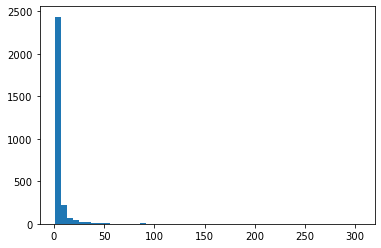

In [7]:
import matplotlib.pyplot as plt

plt.hist(joinedDf['Charger count'].loc[joinedDf['Charger count'] > 0], bins = 50)
plt.show()

## Mapping chargers

Before running our random forest model, we mapped out the number of chargers that are between Q1 and Q3 and exclude census tracts without chargers.

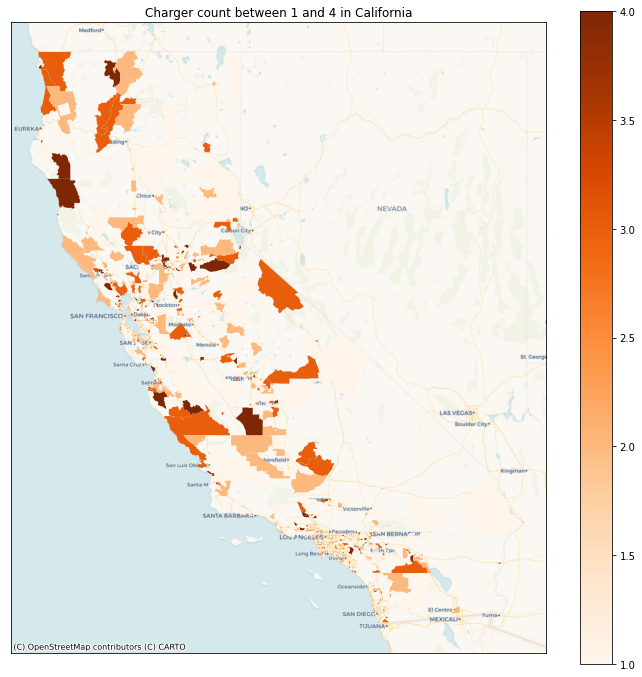

In [28]:
import matplotlib.pyplot as plt
import contextily as ctx

chargers_q1_q3 = joinedDf[(joinedDf['Charger count'] > 0) & (joinedDf['Charger count'] < 4.1)]

fig, ax = plt.subplots(figsize=(12, 12))
chargers_q1_q3.to_crs("EPSG: 3857").plot('Charger count', cmap = 'Oranges',  ax = ax, legend = True)

#remove tix labels
ax.set_xticks([])
ax.set_yticks([])

ax.set_title('Charger count between 1 and 4 in California')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)


This map shows that out of the 75% of census tracts with EV chargers, most of them are located on the coast and are clustered around areas with a huge population such as the Bay and the Greater Los Angeles Area. 

In [35]:
print(' There are a total of ' + str(len(chargers_q4)) + ' census tracts that has more than 4 EV chargers in California.')

 There are a total of 710 census tracts that has more than 4 EV chargers in California.


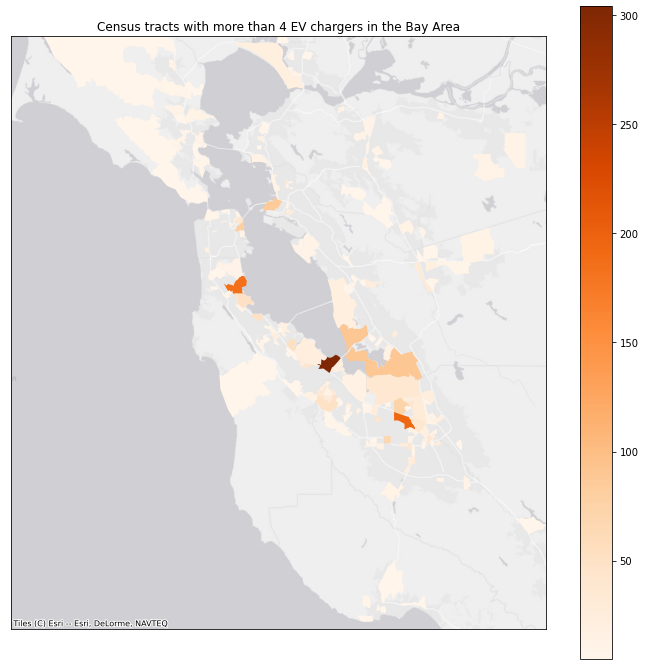

In [41]:
chargers_q4 = joinedDf[(joinedDf['Charger count'] > 4)]

fig, ax = plt.subplots(figsize=(12, 12))
chargers_q4.to_crs("EPSG: 3857").plot('Charger count', cmap = 'Oranges',  ax = ax, legend = True)

#remove tix labels
ax.set_xticks([])
ax.set_yticks([])

#set bounding box
xlim = (-13691777.9143, -13534929.1322)
ylim = (4429751.5172,4603416.4455)

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_title('Census tracts with more than 4 EV chargers in the Bay Area')
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldGrayCanvas)


We zoomed into the Bay area and found that some of the census tracts with the highest number of chargers can be found here, which is not surprising.

## Running a Random Forest Model

In this section, we run a random forest model to estimate whether a census tract has EV chargers. First we create a binary variable to indicate whether a census tract has a charger or not.

In [9]:
joinedDf['hasChargers'] = joinedDf['Charger count'].apply(lambda x: True if x > 0 else False)

Here we extract the coordinates of the centroid as variables. 

In [66]:
joinedDf['Center_point'] = joinedDf['geometry'].centroid
joinedDf["long"] = joinedDf.Center_point.map(lambda p: p.x)
joinedDf["lat"] = joinedDf.Center_point.map(lambda p: p.y)

Then we specify our x (predictor) variables and y variable `hasChargers`. 

In [67]:
from sklearn.model_selection import train_test_split

xvars = ['long', 'lat', 'TotPop19', 'CIscore', 'CIscoreP',
       'Ozone', 'OzoneP', 'PM2_5', 'PM2_5_P', 'DieselPM', 'DieselPM_P',
       'Pesticide', 'PesticideP', 'Tox_Rel', 'Tox_Rel_P', 'Traffic',
       'TrafficP', 'DrinkWat', 'DrinkWatP', 'Lead', 'Lead_P', 'Cleanup',
       'CleanupP', 'GWThreat', 'GWThreatP', 'HazWaste', 'HazWasteP',
       'ImpWatBod', 'ImpWatBodP', 'SolWaste', 'SolWasteP', 'PollBurd',
       'PolBurdSc', 'PolBurdP', 'Asthma', 'AsthmaP', 'LowBirtWt', 'LowBirWP',
       'Cardiovas', 'CardiovasP', 'Educatn', 'EducatP', 'Ling_Isol',
       'Ling_IsolP', 'Poverty', 'PovertyP', 'Unempl', 'UnemplP', 'HousBurd',
       'HousBurdP', 'PopChar', 'PopCharSc', 'PopCharP', 'Child_10',
       'Pop_10_64', 'Elderly65', 'Hispanic', 'White', 'AfricanAm', 'NativeAm',
       'OtherMult',  'AAPI', 'DP04_0006E', 'DP04_0007E', 'DP04_0008E', 'DP04_0009E', 'DP04_0010E',
       'DP04_0011E', 'DP04_0012E', 'DP04_0013E', 'Median Income', 'Median Rent', 'S1501_C01_001E', 'S1501_C01_002E', 'S1501_C01_003E', 'S1501_C01_004E', 
       'S1501_C01_005E', 'S1501_C01_006E', 'S1501_C01_007E', 'S1501_C01_008E', 'S1501_C01_009E', 'S1501_C01_010E', 'S1501_C01_011E', 'S1501_C01_012E', 
       'S1501_C01_013E', 'S1501_C01_014E', 'S1501_C01_015E', 'S1501_C01_016E', 'S1501_C01_017E', 'S1501_C01_018E', 'S1501_C01_019E', 'S1501_C01_020E', 'S1501_C01_021E', 
       'S1501_C01_022E', 'S1501_C01_023E', 'S1501_C01_024E', 'S1501_C01_025E', 'S1501_C01_026E', 'S1501_C01_027E' ]
yvar = 'hasChargers'

We then drop our null values and specify our training and testing dataset.

In [68]:
# create a dataframe with no NaNs
df_to_fit = joinedDf[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

print(len(X_train), len(y_train) )
print(len(X_test), len(y_test) )

5143 5143
1715 1715


We run our Random Forest model and apply our predictions to the testing census tracts.

In [69]:
from sklearn.ensemble import RandomForestClassifier

# initialize the random forest classifer object
rf = RandomForestClassifier(n_estimators = 50, random_state = 1)

# now fit the model
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=1)

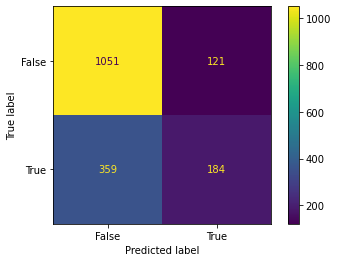

In [70]:

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [71]:
print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, y_pred)))

Accuracy score: 0.7201


In [72]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.75      0.90      0.81      1172
        True       0.60      0.34      0.43       543

    accuracy                           0.72      1715
   macro avg       0.67      0.62      0.62      1715
weighted avg       0.70      0.72      0.69      1715



The classification score shows that the fraction of True positive compared to the number of predicted positives is lower than False positives. The confusion matrix reaffirms this as well. To investigate what contributes to the accuracy of the model, we look into feature importance.

Text(0, 0.5, 'Mean decrease in impurity')

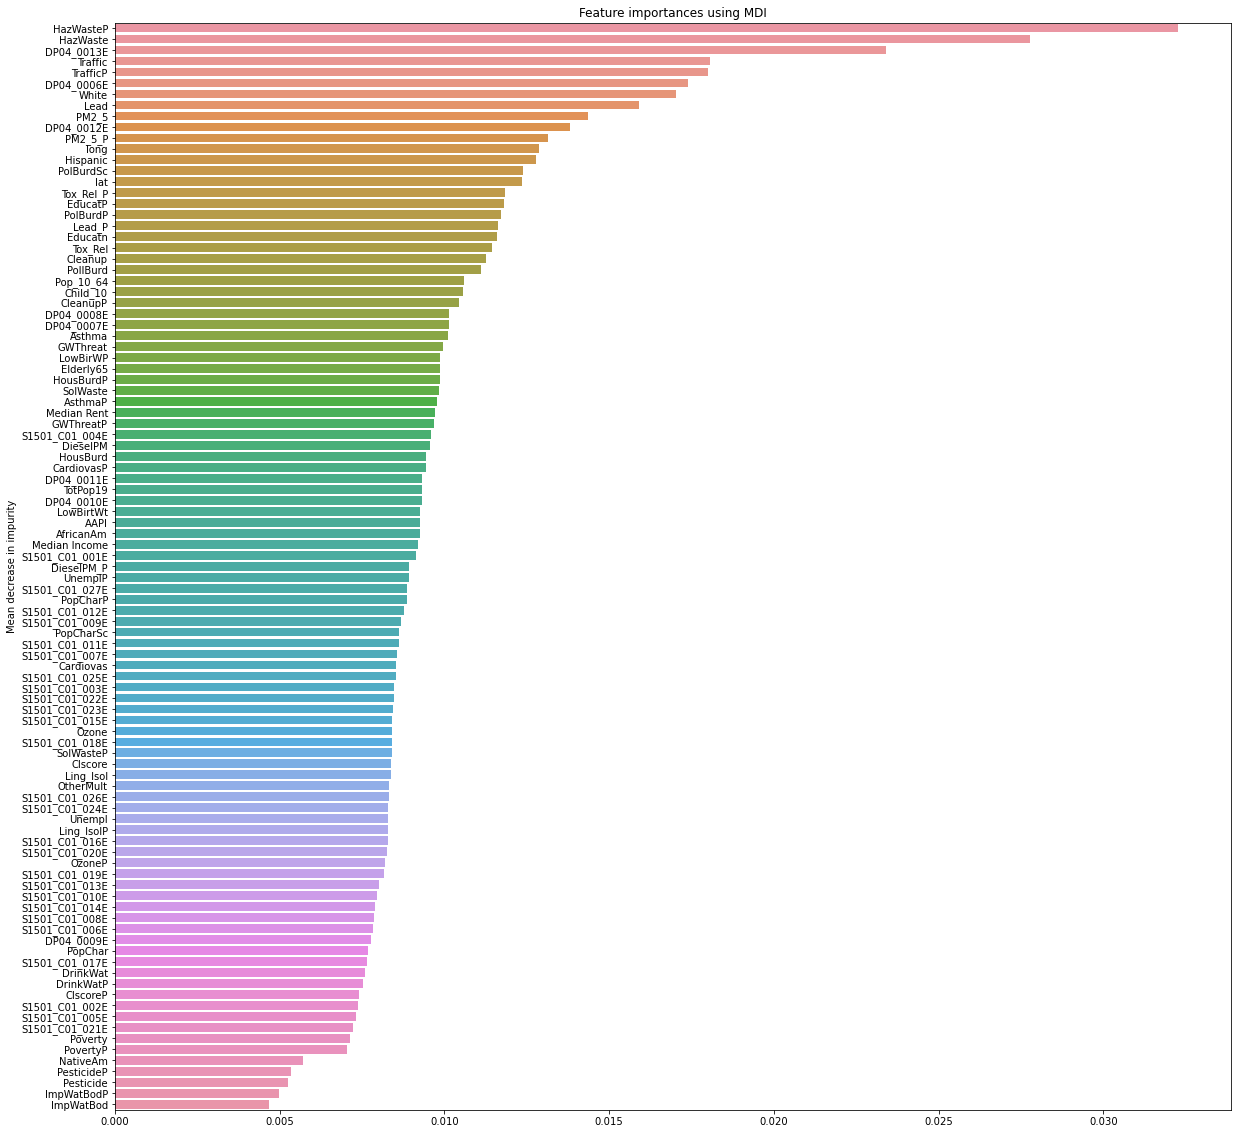

In [73]:
# code from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

import numpy as np
import seaborn as sns

importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize = (20,20))
sns.barplot(x=forest_importances.values, y=forest_importances.index, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

The feature importance graph shows that `HazWaste` is the greatest predictive factor for where EV chargers are built, which is surprising. Does this imply EV chargers are in census tracts with more or less hazardous waste? Other predictive factors include `DP04_0013E` (Total housing units!!20 or more units), `DP04_0006E` (UNITS IN STRUCTURE!!Total housing units), `Traffic`, and `White`. Median income, median rent, and education attainment variables, however, are less important than we thought they would be.   

We can also map the predictions by creating a dataframe with probability of whether a census tract has chargers. 

In [92]:
predictions = pd.DataFrame(rf.predict_proba(X_test), 
                           columns = ['pred_noCharger', 'pred_Charger']).join(X_test.reset_index())

In [95]:
predictions = gpd.GeoDataFrame(predictions, 
                    geometry = gpd.points_from_xy(
                        predictions.long, 
                        predictions.lat, crs='EPSG:3310'))

In [96]:
predictions = gpd.sjoin(joinedDf, predictions)

In [97]:
predictions.head()

,Tract,ZIP,County,ApproxLoc,TotPop19_left,CIscore_left,CIscoreP_left,Ozone_left,OzoneP_left,PM2_5_left,...,S1501_C01_018E_right,S1501_C01_019E_right,S1501_C01_020E_right,S1501_C01_021E_right,S1501_C01_022E_right,S1501_C01_023E_right,S1501_C01_024E_right,S1501_C01_025E_right,S1501_C01_026E_right,S1501_C01_027E_right
5,6083002008,93455,Santa Barbara,Orcutt,7074,9.958479,12.808875,0.036244,13.615432,7.724757,...,234,915,915,235,1739,1344,489,984,935,121
29,6083003007,93110,Santa Barbara,Eastern Goleta Valley,3536,6.783083,6.328795,0.039755,20.846297,7.736183,...,176,520,451,137,1021,899,168,616,527,135
30,6083002932,93117,Santa Barbara,Unincorporated Santa Barbara County area,2273,15.768630,27.269289,0.039421,17.672682,6.761950,...,75,238,192,81,947,926,381,301,243,103
42,6083001208,93109,Santa Barbara,Santa Barbara,4331,9.889371,12.632375,0.039755,20.846297,7.786439,...,254,480,479,442,966,848,537,615,591,341
48,6083002005,93455,Santa Barbara,Orcutt,5691,9.185857,11.031266,0.036244,13.615432,7.472105,...,361,771,744,162,1262,1138,222,1021,902,315


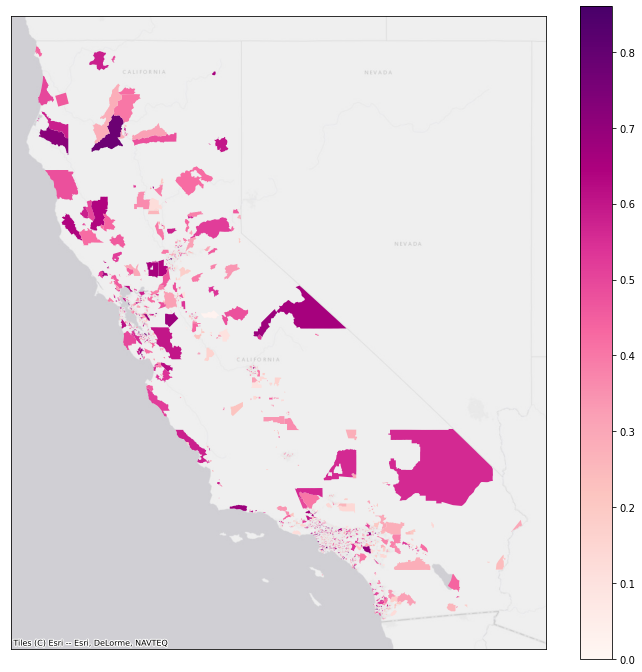

In [102]:
fig, ax = plt.subplots(figsize=(12,12))
predictions.to_crs('EPSG:3857').plot('pred_Charger', ax=ax, legend = True, cmap = 'RdPu')
ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldGrayCanvas)
ax.set_xticks([])
ax.set_yticks([])
plt.show()


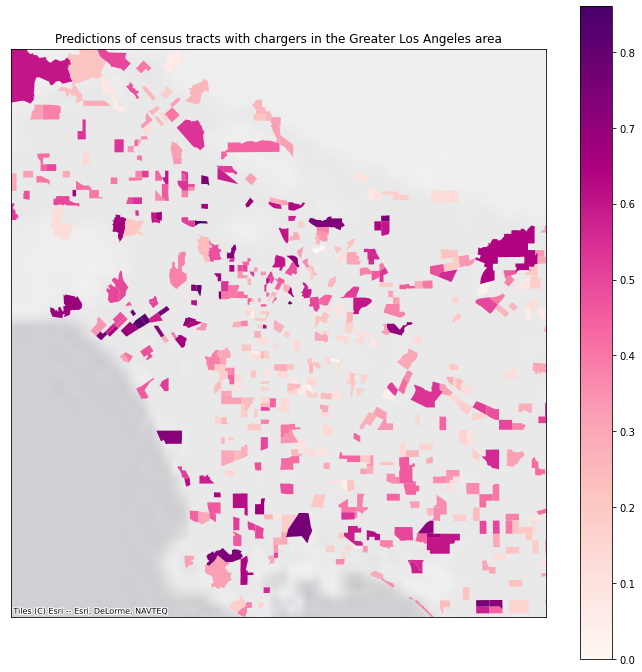

In [107]:
fig, ax = plt.subplots(figsize=(12,12))
predictions.to_crs('EPSG:3857').plot('pred_Charger', ax=ax, legend = True, cmap = 'RdPu')
ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldGrayCanvas)
ax.set_xticks([])
ax.set_yticks([])

#set bounding box
xlim = (-13204989.8940, -13126106.8808)
ylim = (3990199.1917,4073821.3007)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title('Predictions of census tracts with chargers in the Greater Los Angeles area')

plt.show()

As we can see in the map above, census tracts with a high probability of having EV chargers are located in the Westside along the coast, in the Valley, and in Downtown.

## Conclusion

By employing a random forest model, we are able to predict which census tracts are most likely to have EV chargers. We found that income or rent, which are typical variables we associate with EV ownership, is not highly correlated to EV charger presence. This may be due to the fact that many EV owners live in single-family homes which allows them to recharge their cars at home. Moreover, education attainment variables did not score high in feature importance, which may also be relevant to the fact that this analysis is based on EV chargers, not EV ownership. Surprisingly, we found that hazardous waste levels has the largest feature importance. Other factors like traffic level, housing unit number, and White population also had high feature importance. 